# Using movie review text to classify critic ratings
***
In this project I analyze data from movie reviews from the Rotten Tomatoes website. The goal is to predict whether a movie is rated "Fresh" or Rotten" by the critic using only the text of the review submitted by the critic. 

In [1]:
import pandas as pd
import numpy as np

# plotting tools
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

# for data clearning and modeling
from __future__ import division
import datetime
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Rotten Tomatoes Dataset

First I import the dataset and print the first 5 rows to gain a sense of what the dataset contains. 

In [2]:
critics = pd.read_csv('../data/text/critics.csv')
# drop rows with missing text reviews
critics = critics[~critics.quote.isnull()]
print critics.shape
critics.head()

(15561, 8)


,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


For this project the two important columns are the "fresh" column, which contains the critic's rating of the movie, and the "quote" column, which contains the text of the critic's review. 

## Fresh or Rotten?  Example of divided opinions

What do positive and negative reviews tend to look like? For a basic example, I wanted to examine a polarizing movie, one that people tend to either love or hate. The first movie that came to mind was "Dumb and Dumber". Some people (myself included) find this movie to be pretty hilarious, while many others find it to be pretty stupid.  
As I show below, this dataset confirms my suspicion about "Dumb and Dumber": of the 10 reviews, it's a near-even split with 4 "fresh" and 6 "rotten". 

In [3]:
# select reviews for the example 
example = "Dumb & Dumber"
dd = critics[critics.title == example]
# group by fresh column, count rows to show number for each group
dd.groupby('fresh')['title'].count()

fresh
fresh     4
rotten    6
Name: title, dtype: int64

In general, one would hope that the sentiment of the critic about the movie as "fresh" or "rotten" is reflected in the text of the review. For this example I print the review text for a "Fresh" review and "Rotten" review below. 

In [4]:
print example + " Fresh Review"
print dd.loc[2543, 'quote']
print ""
print example + " Rotten Review"
print dd.loc[2546, 'quote']

Dumb & Dumber Fresh Review
Dumb and Dumber, which features Carrey and Jeff Daniels as nitwits traveling cross-country, is a frayed string of gags posing as a movie. Carrey, though, does literal-minded doofdom with peerless enthusiasm.

Dumb & Dumber Rotten Review
Given American cinema's current obsession with innocence and ignorance, at least this never romanticises its protagonists. They are genuinely, irredeemably, 100 per cent no-hopers.


This example immediately illustrates the challenges of text classification. 

The text of the "fresh" review does not convey a strong sense of positivity, referring to the characters as "nitwits" and the movie as "frayed string of gags". The "rotten" review doesn't clearly communicate whether the critic felt positively or negatively about the movie.  

## Exploratory Analysis

First I conduct some exploratory data analysis to learn more about this dataset. 

In [5]:
print("Total number of reviews: {:d}".format(len(critics)))
print("Number of unique critics: {:d}".format(critics.rtid.unique().size))
print("Number of unique movies:  {:d}".format(critics.critic.unique().size))

Total number of reviews: 15561
Number of unique critics: 1921
Number of unique movies:  623


The code below produces a new table with a row for each critic, with columns for the critic's total number of reviews and their mean of "fresh" ratings, which is just the percentage of all their reviews that they gave a fresh rating. 

In [6]:
df = critics.copy()
# create boolean column from fresh column
df['fresh'] = df.fresh == 'fresh'
# group data by critic, create aggregate measures
def func_agg(x):
    names = {'rev_count': x['fresh'].count(),
             'pct_fresh':  x['fresh'].mean()}
    return pd.Series(names, index=['rev_count', 'pct_fresh'])
gbdf = df.groupby('critic').apply(func_agg)
gbdf['pct_fresh'] = gbdf['pct_fresh'] * 100
gbdf.head()

,rev_count,pct_fresh
critic,,
A.D. Murphy,13.0,100.000000
A.H. Weiler,17.0,70.588235
A.O. Scott,19.0,36.842105
Aaron Hillis,2.0,100.000000
Abel Green,5.0,100.000000


Here I examine the critics' percentages of "fresh" ratings in a histogram, which shows the amount of critics that had various percentages of "fresh" ratings, from 0% fresh up to 100% fresh. 

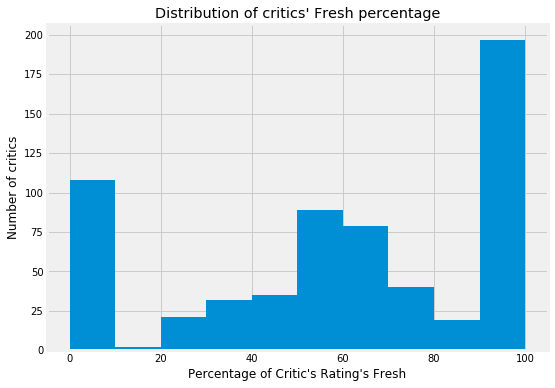

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(gbdf['pct_fresh'])
plt.xlabel("Percentage of Critic's Rating's Fresh")
plt.ylabel('Number of critics')
plt.title("Distribution of critics' Fresh percentage")
plt.show()

There's a large number of critics at 0% and 100%, meaning their reviews were either all rotten or all fresh. 

This makes it seem like most critics either like or hate everything that they see, but my hunch is that these are mostly critics with a small number of reviews.

To investigate this hunch I select the critics with either 0% or 100% of their ratings as fresh.

In [8]:
extreme = gbdf[(gbdf['pct_fresh'] == 100.0) | (gbdf['pct_fresh'] == 0)]

Then, I group the table by review count and count the rows.

In [9]:
extreme.groupby('rev_count')['rev_count'].count()

rev_count
1.0     221
2.0      46
3.0      15
4.0       5
5.0       6
6.0       1
8.0       2
9.0       2
10.0      1
11.0      1
13.0      1
16.0      1
Name: rev_count, dtype: int64

In [10]:
one_review = extreme[extreme['rev_count'] == 1].shape[0] / extreme.shape[0]
print "Percentage of extreme with one review: {}".format(one_review)

Percentage of extreme with one review: 0.73178807947


Most of the 100% or 0% fresh critics have only submitted a handful of reviews, and 73% of these reviewers have only submitted one review. 

Here I remove the critics with less than 3 reviews, and plot the distribution of Fresh percentages again. 

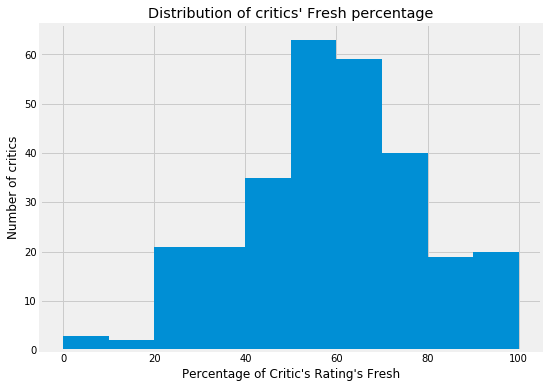

In [11]:
atleast_3 = gbdf[gbdf['rev_count'] > 3]
plt.figure(figsize=(8, 6))
plt.hist(atleast_3['pct_fresh'])
plt.xlabel("Percentage of Critic's Rating's Fresh")
plt.ylabel('Number of critics')
plt.title("Distribution of critics' Fresh percentage")
plt.show()

This looks more like what I would expect. For the most part, critics submit a fresh rating 20-80% of the time. However, a few of the critics still have only "Fresh" ratings. 

## Data Cleaning and Preparation

Before I train models to classify the reviews as "Fresh" or "Rotten", I will remove some of the data for later testing. By holding this data out, I can use it later to get a "true" estimate of classification performance on future, uncollected data. 

I chose to use the most recent 20% of ratings as the test set. I could have used a random split of the reviews to divide the data into a training set and test set, but using the latest 20% of the reviews is more similar to a real-world scenario, where existing data would be used to train a model that predicts ratings from future data. 

Here I convert the string date to python's datetime format, sort the data by date, and return the date at the 80th percentile. Using this data as marker, I create a True/False column to note whether a review occurs after this date. Rows marked as "False" will be my training set, "True" will be the test set.  

In [12]:
# convert to review date to datetime format
df['date'] = df['review_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df = df.sort_values('date')

# set the latest 20% of reviews as the test set
df['date'].quantile(q=0.8)
df['test'] = df['date'] > df['date'].quantile(q=0.8)

In [13]:
# confirm the dftest = True rows comprise 20% of dataset
np.sum(df.test) / df.shape[0]

0.1999871473555684

In [14]:
# create train and test dataframes
dftrain = df.loc[df.test == False]
dftest = df.loc[df.test == True]

I also create separate training and test arrays for the target variable, which is the "fresh" rating. 

In [15]:
# create target array, training and test sets
# convert boolean "fresh" column to array of integers
y = df['fresh'].values * 1

# use boolean array to divide to training and test
ytrain = y[df.test == False]
ytest = y[df.test == True]

In [16]:
# save datsets for easier importing later
dftrain.to_csv('../data/text/critics_train.csv')
dftest.to_csv('../data/text/critics_test.csv')

## Converting text data to numerical format

Most classification algorithms cannot take raw text as input, which means I need to convert the review text into a numeric format algorithms will understand. 

One strategy for this problem involves creation of a term frequency matrix. 

To understand what a term frequency matrix is, consider this simple example.

In [17]:
# make up 2 reviews with similar words
review0 = 'This movie was good'
review1 = 'Awful, awful. This movie was not good'
ex_data = pd.DataFrame({'review': [review0, review1]})
ex_data

,review
0,This movie was good
1,"Awful, awful. This movie was not good"


The table above contains 2 made-up reviews. The text for both reviews is almost exactly the same, except the second review has the additional words, "Awful, awful", and "not good" instead of "good". 

To convert these reviews to a term frequency matrix, I use a vectorizer. The vectorizer treats the 2 reviews as separate "documents" that use a common vocabulary. The vocabulary comes directly from the documents, and so this vocabulary is just a collection of all the unique words across all of the documents. 

Fitting the vectorizer allows it to learn all the words contained in the documents. Here I fit the vectorizer to the two made-up reviews and print the vocabulary. 

In [18]:
vectorizer = CountVectorizer()
vectorizer.fit(ex_data['review'])
vocab = vectorizer.get_feature_names()
print vocab

[u'awful', u'good', u'movie', u'not', u'this', u'was']


The vocabulary simply contains all of the unique words that occurred in the reviews. 
Now that the vectorizer has "learned" the vocabulary from the reviews, it can be used to transform the reviews into the term frequency matrix. 

In [19]:
tfm = vectorizer.transform(ex_data['review'])
print "Term Frequency Matrix"
print pd.DataFrame(tfm.toarray(), columns=vocab)
print review0
print review1

Term Frequency Matrix
   awful  good  movie  not  this  was
0      0     1      1    0     1    1
1      2     1      1    1     1    1
This movie was good
Awful, awful. This movie was not good


As you can see above, the term frequency matrix simply counts the number of occurrences of each word in each document.

I can follow this same process to convert the 15,000 reviews in the Rotten Tomatoes dataset. 

In [20]:
# fit vectorizer to all reviews
vectorizer = CountVectorizer()
vectorizer.fit(df['quote'])

# transform training set
xtrain = vectorizer.transform(dftrain['quote'])

# transform test set
xtest = vectorizer.transform(dftest['quote'])

In [21]:
print xtrain.shape
print xtest.shape

(12449, 22417)
(3112, 22417)


The xtrain and xtest objects now contain the term frequency matrix for the training and test sets. 

The columns of these datasets are now "features" that we can use to train a classification algorithm, with the features being the number of times a word appears in a review. 

## Classifying reviews from term frequencies

I am now ready to use the term frequency matrix to train a model to classify reviews as "Fresh" or "Rotten". 

For a baseline classification model, I use the Naive Bayes classifier. This classifier tends to perform fairly well on text classification tasks without much tweaking or input from the user. 

I use cross-validation to assess classifier performance, with 5 cross-validation folds. I train the model using 4/5 of the data, and use the trained model to make predictions for the remaining 1/5. This process repeats 5 times, and the cross-validation score is the average across the 5 folds.

In [22]:
#set up and fit classifier
clf = MultinomialNB()

# create cross-validation generator
skf = StratifiedKFold(n_splits = 5, random_state=3950)

# make cross-validated predictions
prdscv = cross_val_predict(clf, xtrain, ytrain, cv=skf)

I also collect full training set predictions to assess the gap between training and cross-validation performance. 

In [23]:
# fit classifier to trainig set and make predictions
prdstrn = clf.fit(xtrain, ytrain).predict(xtrain)

For a metric of classification performance, I use accuracy score, which is the percentage of correct predictions out of the total number of predictions. I also inspect the confusion matrix from the cross-validated predictions. 

In [24]:
# predict accuracy scores for both training and test sets
print "Training accuracy: %r" % (accuracy_score(ytrain, prdstrn))
print "Cross-validation accuracy: %r" % (accuracy_score(ytrain, prdscv))
confusion_matrix(ytrain, prdscv)

Training accuracy: 0.919431279620853
Cross-validation accuracy: 0.7632741585669531


array([[3136, 1870],
       [1077, 6366]], dtype=int64)

The default Naive Bayes algorithm has cross-validation accuracy of 76%.

Here I try a slightly different Bernoulli Naive Bayes classifier. Instead of a term frequency matrix, this algorithm takes as input a term occurrence matrix. Instead of a term count, the matrix values indicate whether the word was or was not in the critique. Often times this algorithm performs better with shorter documents. 

In [25]:
# create a binary term matrix
vectorizer = CountVectorizer(binary=True)
xtrain_bin = vectorizer.fit_transform(dftrain['quote'])

# set up Bernoulli model
clf = BernoulliNB()
prdscv = cross_val_predict(clf, xtrain_bin, ytrain, cv=skf)
prdstrn = clf.fit(xtrain, ytrain).predict(xtrain)
print "Training accuracy: %r" % (accuracy_score(ytrain, prdstrn))
print "Cross-validation accuracy: %r" % (accuracy_score(ytrain, prdscv))
confusion_matrix(ytrain, prdscv)

Training accuracy: 0.8983050847457628
Cross-validation accuracy: 0.745039762229898


array([[2850, 2156],
       [1018, 6425]], dtype=int64)

The Bernoulli Naive Bayes model produces slightly lower cross-validation accuracy, at 74.3%. 

Since the standard Naive Bayes classifier performed better in cross-validation, I use this model to fit to the full training data, predict ratings on the test set, and examine accuracy of the test set predictions. 

In [26]:
clf = BernoulliNB()
clf.fit(xtrain, ytrain)
prds_test = clf.predict(xtest)
print "Test accuracy: %r" % (accuracy_score(ytest, prds_test))

Test accuracy: 0.765745501285347


Accuracy on the 20% of ratings I held out is 76.6%, very similar to the cross-validation accuracy. 

### Examining Prediction Errors

The standard naive bayes algorithm fit to the basic term frequency matrix misclassifies the review about 23% of the time. Inspecting some of the mistakes may help me decide how to improve on these results. 

Below I look at some of the biggest "mistakes" made by the model: true "fresh" ratings that were estimated to have low probabilities of "fresh", and true "rotten" ratings estimated to have a high probability of "fresh". 

In [27]:
# get estimated probabilities of "fresh" rating
vectorizer = CountVectorizer()
xtrain = vectorizer.fit_transform(dftrain['quote'])
clf = MultinomialNB()
probs = cross_val_predict(clf, xtrain, ytrain, cv=skf, method='predict_proba')[:, 1]

In [28]:
# return indices of lowest "fresh" probability for true fresh ratings
tfresh_protten = np.argsort(probs[ytrain==1])[0:5]
# highest "fresh" probability for true rotten ratings
trotten_pfresh = np.argsort(probs[ytrain==0])[-5:]

In [29]:
print("Rating is Fresh, Model Predicted it as Rotten")
print('---------------------------')
for i in tfresh_protten:
    print round(probs[ytrain==1][i], 5)
    print dftrain[ytrain == 1].title.iloc[i]
    print(dftrain[ytrain == 1].quote.iloc[i])
    print("")

Rating is Fresh, Model Predicted it as Rotten
---------------------------
3e-05
Still Breathing
A gooey, swooning swatch of romantic hyperventilation, its queasy charms. And let it be said that surrendering to those charms could be as guilt-inducing as polishing off a pint of Haagen-Dazs chocolate ice cream before lunch.

8e-05
South Park: Bigger Longer & Uncut
Certain, probably arrested, personalities (like mine) just find this kind of sh*t pretty funny and any attempt to talk your way around that is, as Cartman would say, blowing bubbles out your *ss.

0.00014
Nochnoy dozor
Although it doesn't have Kate Beckinsale, her guns ablazin', vamped out in the latest vampire-slaying couture, Night Watch is vastly more fun than the similar-themed Underworld pics.

0.00017
Young Frankenstein
Some of the gags don't work, but fewer than in any previous Brooks film that I've seen, and when the jokes are meant to be bad, they are riotously poor. What more can one ask of Mel Brooks?

0.00029
Trust t

It's easy to see why the algorithm misclassified these "fresh" reviews as "rotten": they include many words that are most likely associated with rotten ratings, like "queasy", "hated", "bad", "god-awful", "exploitative", "mess", and "ashamed". 

In [30]:
print("Rating is Rotten, Model Predicted it as Fresh")
print('---------------------------')
for i in trotten_pfresh:
    print round(probs[ytrain==0][i], 5)
    print dftrain[ytrain == 0].title.iloc[i]
    print(dftrain[ytrain == 0].quote.iloc[i])
    print("")

Rating is Rotten, Model Predicted it as Fresh
---------------------------
0.99993
Across the Sea of Time
Employing 3-D and PSE sound, then projected on a screen that suggests a small skyscraper, the new show at West Side Manhattan's Sony IMAX theater is, visually speaking, nothing but a clear day... but it definitely put me in scat-mode.

0.99995
The Waterboy
The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece.

0.99998
Pokémon: The First Movie
This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.

0.99998
King of New York
Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

1.0
Det sjunde inseglet
It survives today only as an unusually pure example of a ty

For these true "rotten" reviews predicted as fresh, I notice several words more commonly associated with positive reviews: "lively", "profound", "enjoyable", "nicely", "popular", and "acceptable".

In [31]:
negwords = ["queasy", "hated", "bad", "awful", "exploitative", "mess", "ashamed"]
poswords = ["lively", "profound", "enjoyable", "nicely", "popular", "acceptable"]

To estiamte the probability of "fresh" from individual words, I create a 2-D matrix of all words in the vocabulary, with a 1 along the diagonal, 0's elswhere, and make predictions from this matrix. This is like predicting the probability of "fresh" if the review contained only one word. 

In [32]:
# fit the model to the training data
clf.fit(xtrain, ytrain)

# create the 2-d matrix for single word occurrence
x = np.eye(xtrain.shape[1])

# get probabilities predicted for single words
probs = clf.predict_proba(x)[:, 1]

In [33]:
# get the vocabulary
words = np.array(vectorizer.get_feature_names())

In [34]:
for w in negwords:
    i = list(words).index(w)
    print w, probs[i]

queasy 0.37585973104125503
hated 0.31897776817773715
bad 0.28418084112860387
awful 0.26729009598751186
exploitative 0.4574315793100554
mess 0.31631826483595005
ashamed 0.5131111618552979


Nearly all these words have probabilities below 0.50, meaning they typically predict a rotten rating. 

In [35]:
for w in poswords:
    i = list(words).index(w)
    print w, probs[i]

lively 0.7759190347896087
profound 0.6930881725587438
enjoyable 0.8326792899122243
nicely 0.7980598958647901
popular 0.8289938160629914
acceptable 0.5131111618552979


All have probabilities above 0.50, meaning they're associated with fresh ratings. 

These errors illustrate the limitations of the "bag-of-words" approach that I used. Each word is considered in isolation, without consideration of the language or context around the word. However, a human understanding of language considers that the interpretation of a review may take on a different sentiment than the sum of its individual parts.

## Summary and Next Steps

I've demonstrated how to convert movie review text into numeric data for use as features for classification algorithms. I tested two versions of the Naive Bayes classifier to predict movie ratings from review text, with the standard Naive Bayes classifier predicting the rating with 76% accuracy. 

By inspecting some predictions that were both highly confident and incorrect, I've also identified areas for potential improvement. Some "Fresh" reviews contained words that are strongly identified with "Rotten" ratings, and vice versa. 

As a follow-up to this project, I can try to improve the classification accuracy, by testing different feature selection approaches, selecting and fine-tuning different classification algorithms, or some combination of both. 